Updating keras

In [ ]:
!pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


Installing and importing necessary libraries

In [ ]:
!pip install tensorflow
!pip install keras_applications
!pip install segmentation_models

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical, Sequence
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import os
from glob import glob
from pathlib import Path
import shutil
from random import sample, choice


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


Mounting my drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Changing the path to the folder where I have saved my dataset (https://www.kaggle.com/datasets/carlolepelaars/camvid) and the unzipped it. Its contains the following directories ['class_dict.csv', 'test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels'] and a class_dict.csv

In [ ]:
cd /content/drive/MyDrive/CamVidDataset/CamVid/

/content/drive/MyDrive/CamVidDataset/CamVid


In [ ]:
!pwd

/content/drive/MyDrive/CamVidDataset/CamVid


In [ ]:
print(os.listdir("/content/drive/MyDrive/CamVidDataset/CamVid/"))

['class_dict.csv', 'test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']


In [ ]:
dataset_path = Path("/content/drive/MyDrive/CamVidDataset/CamVid/")
list(dataset_path.iterdir())

[PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/class_dict.csv'),
 PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/test'),
 PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/test_labels'),
 PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/train'),
 PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/train_labels'),
 PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/val'),
 PosixPath('/content/drive/MyDrive/CamVidDataset/CamVid/val_labels')]

* Collecting file paths for image/label pairs in each dataset split.
* Checking the count of images vs. labels for consistency.
* Defining a target image size (512x512). Though original image size is (960 x 720), resizing it before feeding it to the unet




In [ ]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))

img_size = 512

The number of images matches the number of labels in each split (train, val, test).
If there's a mismatch, the assertion will raise an AssertionError

In [ ]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [ ]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

make_pair is to create (image, label) path pairs based on a naming convention

*   For example: pairs like this
(
 Path("dataset/train/image_001.png"),
 Path("dataset/train_labels/image_001_L.png")
)


In [ ]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))

    return pairs

In [ ]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

Plotting a random train pair to check

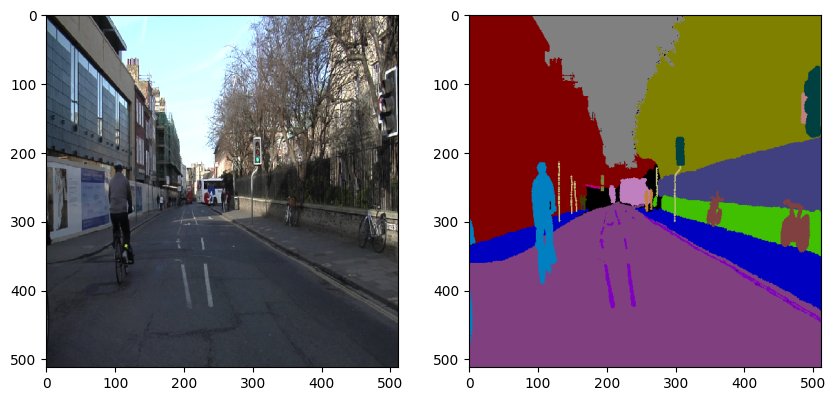

In [ ]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

Reading the class_dict.csv and storing it in class_map_df


In [ ]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv")

 Converting RGB masks into class index masks using this class_map.

In [ ]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))

len(class_map)

32

Checks if every pixel's RGB value in a mask exists in the class_map, to make sure all labels are valid.

In [ ]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

Converts an RGB segmentation mask (3D: H × W × 3) into a 2D label mask (H × W), where each pixel's value is a class index.

In [ ]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)

    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i

    return label

In [ ]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 1,  2,  4,  6,  7,  8,  9, 10, 12, 14, 16, 17, 19, 20, 21, 24, 26,
        27, 30, 31], dtype=uint8),
 array([   68,  4658, 48027,     7,   271,   858, 15773,  2122,   102,
         2875,   150, 84776, 15885,   288, 24888,  2637, 47670,  1620,
         2110,  7359]))

This class loads batches of (image, mask) pairs on the fly and feeds them into the model during training, to avoid RAM overload.

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, pair, class_map, batch_size=4, dim=(512,512,3), shuffle=True,**kwargs):
        'Initialization'
        super().__init__(**kwargs)
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)

        return np.array(batch_imgs) ,np.array(batch_labels)


Creating a DataGenerator instance for train, val and test data

In [ ]:
train_generator = DataGenerator(train_pair+test_pair,class_map,batch_size=16, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

37

In [ ]:
dX,y = train_generator.__getitem__(1)
y.shape

(16, 512, 512, 32)

In [ ]:
val_generator = DataGenerator(val_pair, class_map, batch_size=16, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

6

In [ ]:
test_generator = DataGenerator(test_pair, class_map, batch_size=16, dim=(img_size,img_size,3) ,shuffle=True)
test_steps = test_generator.__len__()
test_steps

14

Enhanced UNet model with attention gates

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, BatchNormalization, Activation, Add, Multiply, UpSampling2D
from tensorflow.keras.models import Model

# Reusable convolutional block with two Conv2D layers + BatchNorm + ReLU, optional Dropout
def conv_block(x, filters, dropout=False, name_prefix="block"):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal', name=f"{name_prefix}_conv1")(x)
    x = BatchNormalization(name=f"{name_prefix}_bn1")(x)
    x = Activation('relu', name=f"{name_prefix}_act1")(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal', name=f"{name_prefix}_conv2")(x)
    x = BatchNormalization(name=f"{name_prefix}_bn2")(x)
    x = Activation('relu', name=f"{name_prefix}_act2")(x)

    if dropout:
        x = Dropout(0.5, name=f"{name_prefix}_dropout")(x)
    return x

# Transposed convolution for upsampling
def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

# Attention gate to suppress irrelevant features during skip connections
# x: encoder feature map
# g: decoder feature map (coarser but semantically rich)
# inter_channels: number of intermediate channels for dimensionality reduction
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1, 1), padding='same')(x) # Transforming encoder feature by applying a 1x1 convolution to the encoder feature map to reduce dimensions
    phi_g = Conv2D(inter_channels, (1, 1), padding='same')(g) # Transforming  decoder feature by appying a 1x1 convolution to the decoder feature map to reduce dimensions
    # Upsampling decoder signal to match encoder dimensions
    upsampled_phi_g = UpSampling2D(size=(theta_x.shape[1] // phi_g.shape[1], theta_x.shape[2] // phi_g.shape[2]))(phi_g) # Now same spatial size as theta_x
    add = Add()([theta_x, upsampled_phi_g]) #Adding the transformed encoder and upsampled decoder features
    act = Activation('relu')(add) #Apply ReLU activation
    psi = Conv2D(1, (1, 1), padding='same')(act)
    sigmoid = Activation('sigmoid')(psi) #Applying sigmoid to get values between 0 and 1 — attention coefficients
    att = Multiply()([x, sigmoid]) # Multiplying attention with encoder features
    return att

# Input layer for RGB images
input_img = Input(shape=(512, 512, 3), name='image_input')

# Encoder (contracting path)
c1 = conv_block(input_img, 16, name_prefix="enc1")
p1 = MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32, name_prefix="enc2")
p2 = MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64, name_prefix="enc3")
p3 = MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128, name_prefix="enc4")
p4 = MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256, name_prefix="enc5")
p5 = MaxPooling2D((2, 2))(c5)

c6 = conv_block(p5, 512, dropout=True, name_prefix="enc6")
p6 = MaxPooling2D((2, 2))(c6)

# Bottleneck layer
c7 = conv_block(p6, 1024, dropout=True, name_prefix="bottleneck")

# Decoder (expanding path) with attention-enhanced skip connections
u8 = upsample_conv(512, (2, 2), strides=(2, 2), padding='same')(c7)
att_c6 = attention_gate(c6, u8, 256)
u8 = concatenate([u8, att_c6])
c8 = conv_block(u8, 512, dropout=True, name_prefix="dec8")

u9 = upsample_conv(256, (2, 2), strides=(2, 2), padding='same')(c8)
att_c5 = attention_gate(c5, u9, 128)
u9 = concatenate([u9, att_c5])
c9 = conv_block(u9, 256, dropout=True, name_prefix="dec9")

u10 = upsample_conv(128, (2, 2), strides=(2, 2), padding='same')(c9)
att_c4 = attention_gate(c4, u10, 64)
u10 = concatenate([u10, att_c4])
c10 = conv_block(u10, 128, name_prefix="dec10")

u11 = upsample_conv(64, (2, 2), strides=(2, 2), padding='same')(c10)
att_c3 = attention_gate(c3, u11, 32)
u11 = concatenate([u11, att_c3])
c11 = conv_block(u11, 64, name_prefix="dec11")

u12 = upsample_conv(32, (2, 2), strides=(2, 2), padding='same')(c11)
u12 = concatenate([u12, c2])
c12 = conv_block(u12, 32, name_prefix="dec12")

u13 = upsample_conv(16, (2, 2), strides=(2, 2), padding='same')(c12)
u13 = concatenate([u13, c1])
c13 = conv_block(u13, 16, name_prefix="dec13")

# Output layer
num_classes = 32  #  different number of classes
output = Conv2D(num_classes, (1, 1), activation='softmax', name='output')(c13)

# Model
seg_model = Model(inputs=input_img, outputs=output)
seg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_conv1 (Conv2D)       │ (None, 512, 512, 16)   │            448 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_bn1                  │ (None, 512, 512, 16)   │             64 │ enc1_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_act1 (Activation)    │ (None, 512, 512, 16)   │              0 │ enc1_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_conv2 (Conv2D)       │ (None, 512, 512, 16)   │          2,320 │ enc1_act1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_bn2                  │ (None, 512, 512, 16)   │             64 │ enc1_conv2[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_act2 (Activation)    │ (None, 512, 512, 16)   │              0 │ enc1_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ enc1_act2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_conv1 (Conv2D)       │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_bn1                  │ (None, 256, 256, 32)   │            128 │ enc2_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_act1 (Activation)    │ (None, 256, 256, 32)   │              0 │ enc2_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_conv2 (Conv2D)       │ (None, 256, 256, 32)   │          9,248 │ enc2_act1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_bn2                  │ (None, 256, 256, 32)   │            128 │ enc2_conv2[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_act2 (Activation)    │ (None, 256, 256, 32)   │              0 │ enc2_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ enc2_act2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc3_conv1 (Conv2D)       │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc3_bn1             

 Total params: 31,484,452 (120.10 MB)

 Trainable params: 31,472,292 (120.06 MB)

 Non-trainable params: 12,160 (47.50 KB)

Initially tried this model but later commented it out. This model was basic unet without Attention gates and Batch Normalisation

In [ ]:
# def upsample_conv(filters, kernel_size, strides, padding):
#     return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


# input_img = Input(shape=(512, 512, 3),name='image_input')
# c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (input_img)
# c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
# p1 = MaxPooling2D((2, 2)) (c1)

# c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
# c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
# p2 = MaxPooling2D((2, 2)) (c2)

# c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
# c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
# p3 = MaxPooling2D((2, 2)) (c3)

# c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
# c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
# c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
# p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

# c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (p5)
# c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (c6)
# p6 = MaxPooling2D(pool_size=(2, 2)) (c6)
# p6 = Dropout(rate=0.5) (p6)

# c7 = Conv2D(1024, (3, 3), activation='relu', padding='same') (p6)
# c7 = Conv2D(1024, (3, 3), activation='relu', padding='same') (c7)
# c7 = Dropout(rate=0.5) (c7)

# u8 = upsample_conv(512, (2, 2), strides=(2, 2), padding='same') (c7)
# u8 = concatenate([u8, c6])
# c8 = Conv2D(512, (3, 3), activation='relu', padding='same') (u8)
# c8 = Conv2D(512, (3, 3), activation='relu', padding='same') (c8)
# c8 = Dropout(rate=0.5) (c8)

# u9 = upsample_conv(256, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c5])
# c9 = Conv2D(256, (3, 3), activation='relu', padding='same') (u9)
# c9 = Conv2D(256, (3, 3), activation='relu', padding='same') (c9)
# c9 = Dropout(rate=0.5) (c9)

# u10 = upsample_conv(128, (3, 3), strides=(2, 2), padding='same') (c9)
# u10 = concatenate([u10, c4])
# c10 = Conv2D(128, (3, 3), activation='relu', padding='same') (u10)
# c10 = Conv2D(128, (3, 3), activation='relu', padding='same') (c10)

# u11 = upsample_conv(64, (2, 2), strides=(2, 2), padding='same') (c10)
# u11 = concatenate([u11, c3])
# c11 = Conv2D(64, (3, 3), activation='relu', padding='same') (u11)
# c11 = Conv2D(64, (3, 3), activation='relu', padding='same') (c11)

# u12 = upsample_conv(32, (2, 2), strides=(2, 2), padding='same') (c11)
# u12 = concatenate([u12, c2])
# c12 = Conv2D(32, (3, 3), activation='relu', padding='same') (u12)
# c12 = Conv2D(32, (3, 3), activation='relu', padding='same') (c12)

# u13 = upsample_conv(16, (2, 2), strides=(2, 2), padding='same') (c12)
# u13 = concatenate([u13, c1], axis=3)
# c13 = Conv2D(16, (3, 3), activation='relu', padding='same') (u13)
# c13 = Conv2D(16, (3, 3), activation='relu', padding='same') (c13)

# d = Conv2D(32, (1, 1), activation='softmax') (c13)


Calculates global IoU (over all pixels and classes)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred, smooth=1e-6):
    """
  Calculates the Intersection over Union (IoU) metric for multi-class segmentation.

  Parameters:
      y_true (tensor): Ground truth one-hot encoded mask (batch, H, W, num_classes)
      y_pred (tensor): Model prediction (softmax probabilities) of the same shape
      smooth (float): Small value to avoid division by zero

  Returns:
      iou_score (float): Scalar IoU value
    """
    y_true = tf.cast(y_true, tf.float32)  # Converts y_true to float32
    y_pred = tf.argmax(y_pred, axis=-1)  # Converts softmax output to class labels
    y_pred = tf.one_hot(y_pred, depth=tf.shape(y_true)[-1], dtype=tf.float32)  # Converts back to one-hot

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection

    return (intersection + smooth) / (union + smooth)

Calculates mean IoU

In [ ]:
def mean_iou(y_true, y_pred, smooth=1e-6):
    """
  Calculates the Mean Intersection over Union (Mean IoU) across all classes.

  Args:
      y_true (tensor): Ground truth one-hot encoded mask (shape: [batch, height, width, num_classes])
      y_pred (tensor): Predicted probabilities from the model (softmax output)
      smooth (float): Small constant to avoid division by zero

  Returns:
      mean_iou (float): Mean IoU across all classes
  """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred, depth=tf.shape(y_true)[-1], dtype=tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])  # Sum over batch, height, width
    union = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2]) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)


Calculates Dice Coefficient

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Computes the Dice Coefficient for multi-class segmentation.

    Args:
        y_true (tensor): Ground truth one-hot encoded mask (shape: [batch, height, width, num_classes])
        y_pred (tensor): Predicted probabilities (softmax output)
        smooth (float): Smoothing constant to avoid division by zero

    Returns:
        dice_score (float): Scalar Dice score (mean over all classes)
    """
    # Convert to float32
    y_true = tf.cast(y_true, tf.float32)

    # Convert softmax output to one-hot encoded predicted labels
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred, depth=tf.shape(y_true)[-1], dtype=tf.float32)

    # Compute intersection and union per class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2])

    # Dice score per class, then mean over classes
    dice = (2.0 * intersection + smooth) / (denominator + smooth)
    return tf.reduce_mean(dice)


In [ ]:
#compiling the segmentation model
seg_model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',iou, mean_iou, dice_coefficient])

ModelCheckpoint: Saves the model weights to this file only if the validation accuracy improves

Early Stopping: Stop training early if validation accuracy doesn't improve for 10 epochs

ReduceLROnPlateau: Reduce the learning rate if validation accuracy plateaus for 10 epochs


In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/drive/MyDrive/CamVidDataset/CamVid/Extended_Unet_Relu_Dropout.weights.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
rl = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=10,verbose=1,mode="max",min_lr=0.0001)

*Reduced train and val steps for testing purpose. Will complete the training faster. Have kept it as comments for testing purpose. *

In [ ]:
# train_steps = 3  # Reduce steps per epoch
# val_steps = 2 # Reduce validation steps

In [ ]:
train_steps, val_steps

(37, 6)

Training the segmentation model using the data generators, for 75 epochs, with validation and callbacks.

*Note: The total training time is approx. 5 hours on A100 GPU. Epoch count can be reduced for testing of the codebase. *

In [ ]:
results = seg_model.fit(train_generator , steps_per_epoch=train_steps ,epochs=75,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[es,rl])

Epoch 1/75
37/37 ━━━━━━━━━━━━━━━━━━━━ 574s 14s/step - accuracy: 0.2505 - dice_coefficient: 0.0533 - iou: 0.1563 - loss: 3.1117 - mean_iou: 0.0394 - val_accuracy: 0.1048 - val_dice_coefficient: 0.1221 - val_iou: 0.0553 - val_loss: 192.8851 - val_mean_iou: 0.1187 - learning_rate: 0.0010
Epoch 2/75
37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step - accuracy: 0.6930 - dice_coefficient: 0.1774 - iou: 0.5309 - loss: 2.0892 - mean_iou: 0.1550 - val_accuracy: 0.3924 - val_dice_coefficient: 0.1990 - val_iou: 0.2442 - val_loss: 5.8243 - val_mean_iou: 0.1839 - learning_rate: 0.0010
Epoch 3/75
37/37 ━━━━━━━━━━━━━━━━━━━━ 257s 7s/step - accuracy: 0.7414 - dice_coefficient: 0.2776 - iou: 0.5895 - loss: 1.6156 - mean_iou: 0.2542 - val_accuracy: 0.5361 - val_dice_coefficient: 0.2218 - val_iou: 0.3663 - val_loss: 2.1859 - val_mean_iou: 0.2052 - learning_rate: 0.0010
Epoch 4/75
37/37 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.7609 - dice_coefficient: 0.3109 - iou: 0.6145 - loss: 1.3054 - mean_iou: 0.2881 - v

In [ ]:
print(results.history.keys())


dict_keys(['accuracy', 'dice_coefficient', 'iou', 'loss', 'mean_iou', 'val_accuracy', 'val_dice_coefficient', 'val_iou', 'val_loss', 'val_mean_iou', 'learning_rate'])


Plotting the graphs

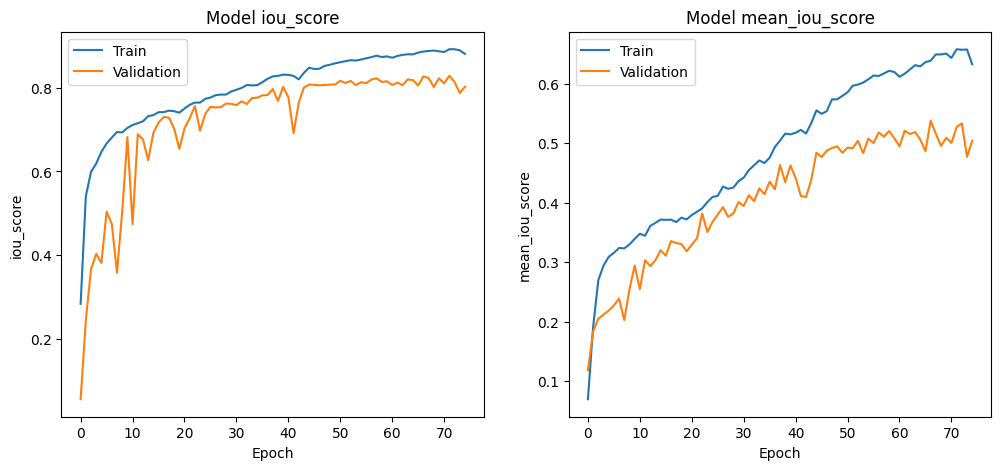

In [ ]:
from matplotlib import pyplot as plt
# Plot training & validation iou values
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(results.history['iou'])
plt.plot(results.history['val_iou'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation mean iou values
plt.subplot(1,2,2)
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('Model mean_iou_score')
plt.ylabel('mean_iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


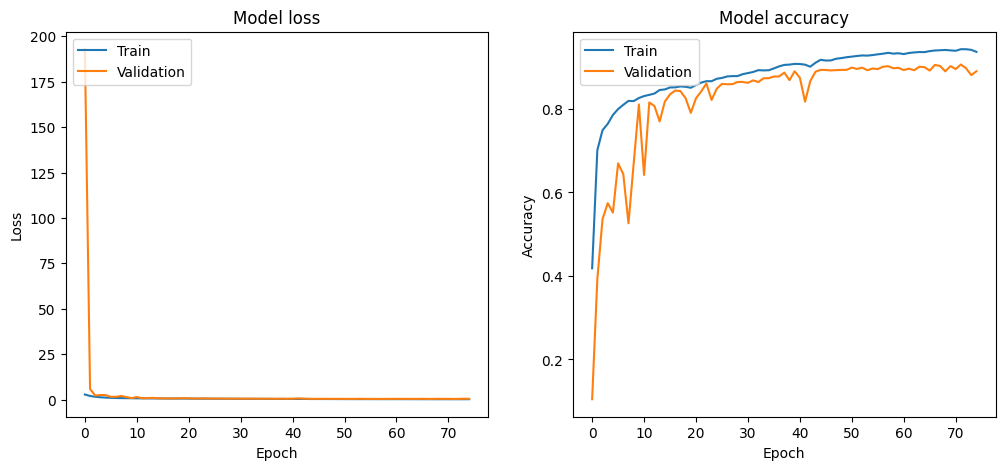

In [ ]:

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



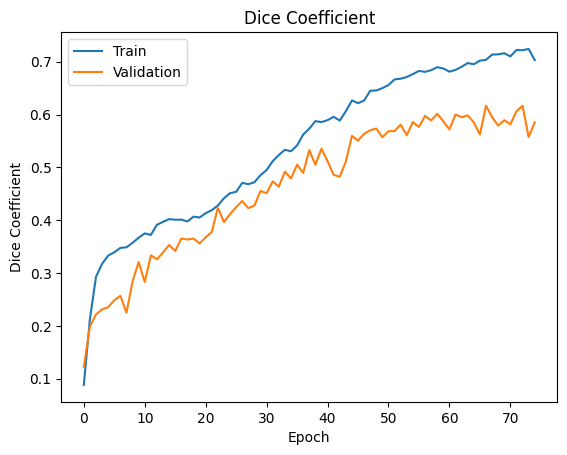

In [ ]:
# Plot training & validation dice coefficient values
plt.plot(results.history['dice_coefficient'])
plt.plot(results.history['val_dice_coefficient'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Selecting a random image and its corresponding mask from the validation set and loading them as NumPy arrays.

In [ ]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

make_prediction: load an image, preprocess it, make a prediction, and return the predicted segmentation label map.

In [ ]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [ ]:
pred_label = make_prediction(seg_model, img_mask[0], (img_size,img_size,3))
pred_label.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(512, 512)

form_colormap: converting the 2D predicted label map into a color image (RGB mask) using a colormap.

In [ ]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [ ]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Plotting original validation image with True and Predicted labels

Text(0.5, 1.0, 'Predicted labels')

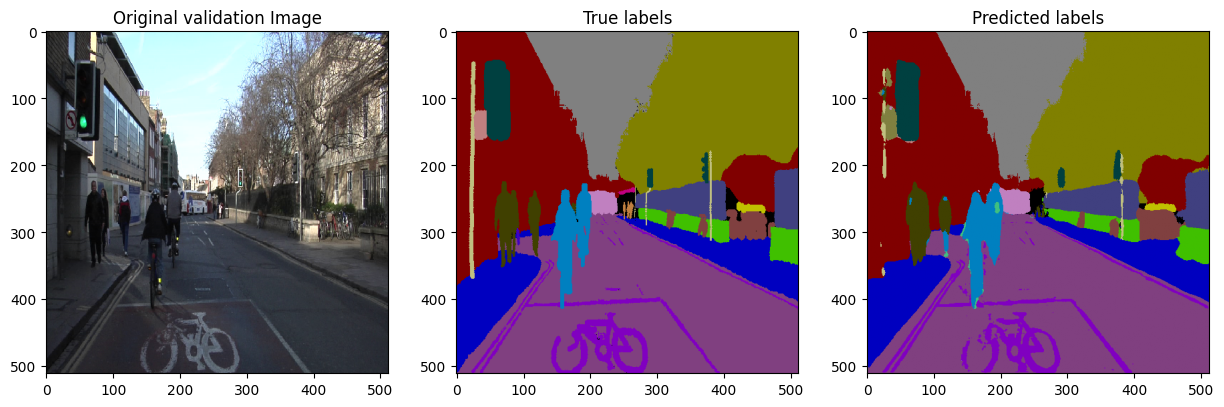

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original validation Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('Predicted labels')

In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_iou, test_mean_iou, test_dice_coefficient = seg_model.evaluate(test_generator, steps=test_steps)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test IoU: {test_iou}")
print(f"Test Mean IoU: {test_mean_iou}")
print(f"Test Dice Coefficient: {test_dice_coefficient}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.9319 - dice_coefficient: 0.7185 - iou: 0.8726 - loss: 0.2176 - mean_iou: 0.6480
Test Loss: 0.21691671013832092
Test Accuracy: 0.9325419068336487
Test IoU: 0.8736343383789062
Test Mean IoU: 0.6394666433334351
Test Dice Coefficient: 0.7098796963691711


Repeating the steps for test images

In [ ]:
img_mask = choice(test_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))


In [ ]:
pred_label = make_prediction(seg_model, img_mask[0], (img_size,img_size,3))
pred_label.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


(512, 512)

In [ ]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Plotting original test image with True and Predicted labels

*NOTE: only the image title has been given as validation image but it is actually from the test set. It was a typing mistake.*

Text(0.5, 1.0, 'predicted labels')

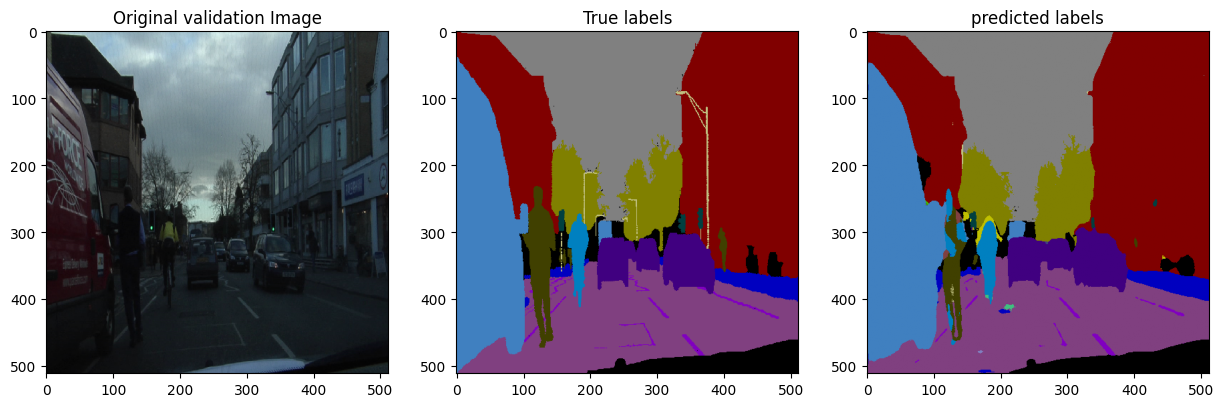

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original validation Image') # This is actually Test image. Title should be Original Test Image.
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')
